# Projeto 1 - Ciência dos Dados

* Nome: Ariel Tamezgui Leventhal (arieltl@al.insper.edu.br)
* Nome: Felipe Liberman Fuchs (felipelf2@al.insper.edu.br)
* Nome: Victoria Leal Garcia de Souza (victorialgs@al.insper.edu.br)

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

## Setup

___
Carregando algumas bibliotecas:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from emoji import UNICODE_EMOJI
import re
from pandas.api.types import CategoricalDtype

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
/home/ariel/naive-bayes-classifier


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [3]:
filename = 'ps5.xlsx'

In [4]:
train = pd.read_excel(filename)
train.head(5)

,Treinamento,Categoria,Unnamed: 2
0,@jamiltdavis @vicious696 i say the cutoff shou...,4,NaN
1,@rgt_85 @obe1plays when @rgt_85 tweets at you....,4,NaN
2,@one_gamergal6 @xboxstockalerts if you guys st...,3,NaN
3,@mbeasleysburner @wario64 they are literally l...,4,NaN
4,first couple followers to give us a private m...,4,NaN


In [5]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Teste,Categoria,gabas
0,"@cataferal hi tom, a couple things. in your f1...",NaN,1
1,@infamizmikep if the conversation is about gam...,NaN,2
2,@jte2409 @mcquack306 no free upgrade from ps4 ...,NaN,2
3,@abduplays_ just in time because i just got a ...,NaN,4
4,y’all gotta ps5?,NaN,4


___
## Classificador automático de sentimento


Faça aqui uma descrição do seu produto e o que considerou como relevante ou não relevante na classificação dos tweets.

O produto escolhido foi o console Playstation 5 (PS5). Para fins de relevância, optamos seguir a seguinte lista: 
</br>
<li> Muito relevante: Tweets que possuem uma crítica (positiva ou negativa) sobre o produto que tenha fundamento em  alguma qualidade ou característica do console.
<li> Relevante: Tweets que possuem uma crítica (positiva ou negativa) sobre o produto sem especificar alguma qualidade ou característica do console.
<li> Pouco Relevante: Tweets que comentam sobre a falta de estoque do PS5 e/ou da dificuldade de comprar um console.
<li> Irrelevante: Tweets que não se encaixam em nenhuma das outras categorias, incluindo: memes, reclamações sobre algum jogo de PS5, promoções e sorteios para conseguir um PS5, entre outros.
</li>
</br>
Tweets que poderiam ser classificados como Relevante mas que contenham alguma proposta de solução a algum problema indicado nos Tweets foram classificados como Muito Relevante, mesmo não tendo comentário específico sobre alguma qualidade ou característica do console. 

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

* $P(Categoria|Texto) = \frac{P(Texto|Categoria) \cdot P(Categoria)}{P(Text)} = \frac{\sum_0^n P(Palavra|Categoria) \cdot P(Categoria)}{P(Text)}$

In [6]:
train.Categoria = train.Categoria.astype('category')
train.Categoria.cat.categories = ["Muito Relevante","Relevante", "Pouco Relevante", "Irrelevante"]

special_letters = {",", "'", '"', ".", "!", "?", ";", ":", "[", "]","{", "}", "(", ")", "#", "/",  "\\", "https","+", "*", "-"}
stopwords = {'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below',
            'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for',
            'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself',
            'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my',
            'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd",
            "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's", 'these',
            'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', "wasn't", 'we', "we'd", "we'll", "we're",
            "we've", 'were', "weren't", 'what', "what's", 'when', "when's", 'where', "where's", 'which', 'while', 'who', "who's", 'whom', 'why', "why's", 'with', "won't", 'would',
            "wouldn't", 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'}

In [7]:
def is_not_user(word): # retorna se uma palavra é um nome de usuario 
    return (not word[0] == "@") if len(word) > 0 else True

def is_not_stopword(word): # retorna se uma palavra é uma stopword
    return not word in stopwords

def is_emoji(letter): # retorna se um caractere é um emoji
    return letter in UNICODE_EMOJI["en"]

def is_special(letter): # retorna se o caractere é um caractere especial
    return letter in special_letters

def is_url(sentence):    
    pattern = re.compile("/(((http|ftp|https):\/{2})+(([0-9a-z_-]+\.)+(aero|asia|biz|cat|com|coop|edu|gov|info|int|jobs|mil|mobi|museum|name|net|org|pro|tel|travel|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cu|cv|cx|cy|cz|cz|de|dj|dk|dm|do|dz|ec|ee|eg|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mn|mn|mo|mp|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|nom|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ra|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|sj|sk|sl|sm|sn|so|sr|st|su|sv|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw|arpa)(:[0-9]+)?((\/([~0-9a-zA-Z\#\+\%@\.\/_-]+))?(\?[0-9a-zA-Z\+\%@\/&\[\];=_-]+)?)?))\b/imuS")
    return not (pattern.match(sentence) is None)

In [8]:
def clean_up(text):
    split_text = text.split()
    
    for sentence in range(len(split_text)):
        if is_url(split_text[sentence]):
            split_text[sentence] = " " # remove URLs
            
    final_text= ""
    
    for letter in " ".join(split_text):
        if is_emoji(letter):
            final_text += f" {letter} " # separa emojis
        elif is_special(letter):
            final_text += " " # filtra caracteres especiais com exceção de "_" para evitar atrapalhar o filtro de nome de usuarios
        else:
            final_text += letter 
    
    return ' '.join(word.replace("_"," ")
                    for word in final_text.split() if 
                    is_not_user(word) and
                    is_not_stopword(word)).strip() # filtra usuários, stopwords, caracteres especiais e "_"

In [9]:
train.head(1)

,Treinamento,Categoria,Unnamed: 2
0,@jamiltdavis @vicious696 i say the cutoff shou...,Irrelevante,NaN


In [10]:
words_count = {cat: dict() for cat in train.Categoria.cat.categories}
words = set()

for i, tweet_data in train.iterrows(): # itera pelas linhas do dataframe
    tweet = tweet_data.Treinamento # separa a coluna do tweet
    
    for word in clean_up(tweet).split(): # faz limpezas no texto
        words.add(word)
        cat_dict = words_count[tweet_data.Categoria]
        cat_dict[word] = cat_dict.get(word, 0)+1 # garante que a palavra existe no dicionario. caso exista o count é incrementado, caso contrário a palavra é adicionada com count=1
        
M = words_count['Muito Relevante']
R = words_count['Relevante']
P = words_count['Pouco Relevante']
I = words_count['Irrelevante']

In [11]:
total = len(words)         # total de palavras no banco de dados
totalM = (sum(M.values())) # total de palavras na categoria Muito Relevante
totalR = (sum(R.values())) # total de palavras na categoria Relevante
totalP = (sum(P.values())) # total de palavras na categoria Pouco Relevante
totalI = (sum(I.values())) # total de palavras na categoria Irrelevante
p_cats = train.Categoria.value_counts()/len(train) #probabilidade de um tweet ser cada categoria

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [12]:
l = [] # lista de classificações, mesma ordem de test

for i, tweet_data in test.iterrows():  # itera pelas linhas do dataframe
    # valores inicias para a probabilidade do tweet ser determinada relevancia, começa em probabilidade da categoria para
    # sera multiplicado pela probabilidade de cada palavra ser cada categoria.
    i = p_cats["Irrelevante"]
    p = p_cats["Pouco Relevante"]
    r = p_cats["Relevante"]
    m = p_cats["Muito Relevante"]
    tweet = tweet_data.Teste # separa a coluna do tweet
    
    # faz limpezas no texto
    for word in clean_up(tweet).split(): 
        
        # calcula as probabilidades de cada relevancia fazendo suavizavao de laplace
        r *= (R.get(word, 0) + 1) / (totalR + total) 
        p *= (P.get(word, 0) + 1) / (totalP + total) 
        i *= (I.get(word, 0) + 1) / (totalI + total) 
        m *= (M.get(word, 0) + 1) / (totalM + total)
        
    result = {"Muito Relevante": m,"Relevante": r,"Pouco Relevante": p,"Irrelevante": i} # dicionário para comparar dentro do MAX abaixo
    
    l.append(max(result, key = result.get)) # compara os valores de r, p, i, e adiciona à lista L 

test.Categoria = pd.Categorical(values=l,categories=["Muito Relevante","Relevante", "Pouco Relevante", "Irrelevante"],ordered=True)

In [13]:
test.gabas = test.gabas.astype("category")
test.gabas.cat.categories = test.Categoria.cat.categories

In [14]:
test["Acerto"] = [("Acertou" if (row.gabas==row.Categoria)  else "Errou") for i,row in test.iterrows()]
test.Acerto = test.Acerto.astype('category')


In [15]:
(test.Acerto.value_counts(normalize=True)*100).to_frame()

,Acerto
Acertou,65.6
Errou,34.4


In [16]:
pd.crosstab(test.Categoria,test.gabas)

gabas,Muito Relevante,Relevante,Pouco Relevante,Irrelevante
Categoria,,,,
Muito Relevante,3,0,0,8
Relevante,8,19,3,36
Pouco Relevante,0,0,27,5
Irrelevante,3,17,6,115


In [17]:
pd.crosstab(test.Categoria,test.gabas,normalize="index").round(4)*100

gabas,Muito Relevante,Relevante,Pouco Relevante,Irrelevante
Categoria,,,,
Muito Relevante,27.27,0.00,0.00,72.73
Relevante,12.12,28.79,4.55,54.55
Pouco Relevante,0.00,0.00,84.38,15.62
Irrelevante,2.13,12.06,4.26,81.56


___
### Concluindo

In [18]:
print(totalM)
print(totalR)
print(totalP)
print(totalI)

592
1870
1827
5328


In [19]:
train.Categoria.value_counts()

Irrelevante        312
Relevante           88
Pouco Relevante     74
Muito Relevante     26
Name: Categoria, dtype: int64

In [20]:
test.gabas.value_counts()

Irrelevante        164
Relevante           36
Pouco Relevante     36
Muito Relevante     14
Name: gabas, dtype: int64

# Conclusão

O Classificador Naive-Bayes criado com o dataset de treinamento obteve um acerto de 65.6%. É possível concluir que o classificador teve resultados razoáveis, na média do esperado para um classificador simples. Ele é considerado simples por não levar em conta coisas como duplas-negações, sarcasmo, e outras nuances linguísticas.

A fim de economizar tempo da equipe de marketing do cliente, pode-se afirmar que o classificador cumpriu parcialmente com seus objetivos, porque mesmo tendo dificuldade com as categorias de muito relevante e relevante, ele tem uma boa precisão quanto aos tweets irrelevantes e pouco relevantes. Sem os tweets irrelevantes ou pouco relevantes, a maioria restante são de tweets com algum grau de relevância, e estes são fundamentais para a intervenção da área de marketing.



O classificador ainda não está em um ponto no qual se possa excluir totalmente a análise manual dos tweets uma vez que 45.6% dos tweets ainda são classificados incorretamente, que são em sua maioria tweets muito relevantes ou relevantes. Isto pode ter sido causado por diferenças de interpretação na classificação manual dos tweets, mas também é afetado pelo não-reconhecimento de coisas como o sarcasmo que já foram citadas. Como plano de melhoria e motivo para continuação do investimento no projeto, seria interessante expandir o dataset em análise com a classificação manual feita por pessoas da área de marketing, melhorando a confiabilidade nos dados do dataset de treinamento. Outra solução que possa ser mais factível de realizar a curto prazo seria procurar adicionar à base de treinamento tweets para melhor treinar o classificador, de maneira que tenha uma proporção mais igual entre a quantidade de tweets de cada categoria. Outra possível melhoria seria implementar detecção de ironia, para isso poderíamos usar esta [pesquisa](https://aclanthology.org/S18-1005/).

Sobre a necessidade de investimento adicional no dataset de treinamento, não é possível criar um novo dataset automaticamente através do próprio classificador já existente pois isso propagaria os erros feitos pelo classificador, reduzindo sua exatidão.

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [21]:
df1 = pd.read_excel(filename)
df2 = pd.read_excel(filename, sheet_name = 'Teste')
df1 = df1.drop("Unnamed: 2",axis=1)
df2 = df2.drop("Categoria",axis=1)
df1 = df1.rename(columns={"Treinamento":"Tweet"})
df2 = df2.rename(columns={"Teste":"Tweet","gabas":"Categoria"})

In [22]:
tweets = pd.concat([df1,df2],ignore_index=True)
tweets.Tweet = tweets.Tweet.apply(clean_up)
tweets.Categoria = tweets.Categoria.astype('category')
tweets.Categoria.cat.categories = ["Muito Relevante","Relevante", "Pouco Relevante", "Irrelevante"]

tweets.Categoria.cat.categories

Index(['Muito Relevante', 'Relevante', 'Pouco Relevante', 'Irrelevante'], dtype='object')

In [23]:
def train_classifier(df):
    words_count = {cat: dict() for cat in df.Categoria.cat.categories}
    words = set()
    for i, tweet_data in df.iterrows(): # itera pelas linhas do dataframe
        tweet = tweet_data.Tweet # separa a coluna do tweet

        for word in tweet.split(): # faz limpezas no texto
            words.add(word)
            cat_dict = words_count[tweet_data.Categoria]
            cat_dict[word] = cat_dict.get(word, 0)+1 # garante que a palavra existe no dicionario. caso exista o count é incrementado, caso contrário a palavra é adicionada com count=1
    return words, words_count, df.Categoria.value_counts()/len(df)

In [24]:
def test_classifier(words,words_count,p_cats,df):

    M = words_count['Muito Relevante']
    R = words_count['Relevante']
    P = words_count['Pouco Relevante']
    I = words_count['Irrelevante']

    total = len(words)         # total de palavras no banco de dados
    totalM = (sum(M.values())) # total de palavras na categoria Muito Relevante
    totalR = (sum(R.values())) # total de palavras na categoria Relevante
    totalP = (sum(P.values())) # total de palavras na categoria Pouco Relevante
    totalI = (sum(I.values())) # total de palavras na categoria Irrelevante

    l = [] # lista de classificações, mesma ordem de test
    
    for i, tweet_data in df.iterrows():  # itera pelas linhas do dataframe
        # valores inicias para a probabilidade do tweet ser determinada relevancia, começa em probabilidade da categoria para
        # sera multiplicado pela probabilidade de cada palavra ser cada categoria.
        i = p_cats["Irrelevante"]
        p = p_cats["Pouco Relevante"]
        r = p_cats["Relevante"]
        m = p_cats["Muito Relevante"]
        tweet = tweet_data.Tweet # separa a coluna do tweets

        # faz limpezas no texto
        for word in tweet.split(): 

            # calcula as probabilidades de cada relevancia fazendo suavizavao de laplace
            r *= (R.get(word, 0) + 1) / (totalR + total) 
            p *= (P.get(word, 0) + 1) / (totalP + total) 
            i *= (I.get(word, 0) + 1) / (totalI + total) 
            m *= (M.get(word, 0) + 1) / (totalM + total)

        result = {"Muito Relevante": m,"Relevante": r,"Pouco Relevante": p,"Irrelevante": i} # dicionário para comparar dentro do MAX abaixo

        l.append(max(result, key = result.get)) # compara os valores de r, p, i, e adiciona à lista L 

    df["Classificação"] = pd.Categorical(values=l,categories=["Muito Relevante","Relevante", "Pouco Relevante", "Irrelevante"],ordered=True)
  
    df["Acerto"] = ["Acertou" if (row["Classificação"]==row.Categoria) else "Errou" for i,row in df.iterrows()]
    
    df.Acerto = df.Acerto.astype('category')
    return df

In [25]:
lista_acertos = list()
acertos_max = 0
seeds = [(11*i+669+i**2) for i in range(100)] # para manter consistência entre execuções

for i in range(100):
    random_tweets = tweets.sample(frac=1,ignore_index=True,random_state=seeds[i])
    # Separa o df em train e test, com teste de 1/3
    
    train2, test2 =(random_tweets.iloc[:500], random_tweets.iloc[500:])
    result = test_classifier(*train_classifier(train2), test2.copy())
    lista_acertos.append(result.Acerto.value_counts(normalize=True).Acertou*100)
    acertos_max = max(acertos_max,lista_acertos[-1])
    if acertos_max == lista_acertos[-1]:
        max_acertos_test = result

tabela_acertos = pd.DataFrame({"Acertos":lista_acertos})
tabela_acertos.describe()

,Acertos
count,100.00000
mean,63.35200
std,2.57527
min,58.80000
25%,61.20000
50%,63.20000
75%,64.90000
max,70.00000


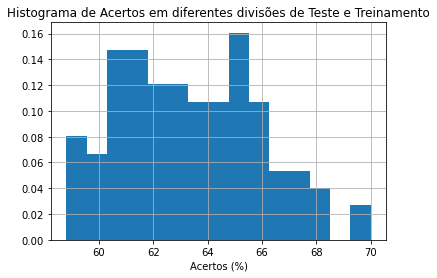

In [26]:
plt.title("Histograma de Acertos em diferentes divisões de Teste e Treinamento")
plt.xlabel("Acertos (%)")
tabela_acertos.Acertos.hist(bins=15,density=True)
plt.show()


In [27]:
pd.crosstab(max_acertos_test["Classificação"],max_acertos_test.Categoria,normalize="index").round(4)*100

Categoria,Muito Relevante,Relevante,Pouco Relevante,Irrelevante
Classificação,,,,
Muito Relevante,25.00,25.00,0.00,50.00
Relevante,11.11,34.92,3.17,50.79
Pouco Relevante,2.70,0.00,83.78,13.51
Irrelevante,2.74,11.64,2.74,82.88


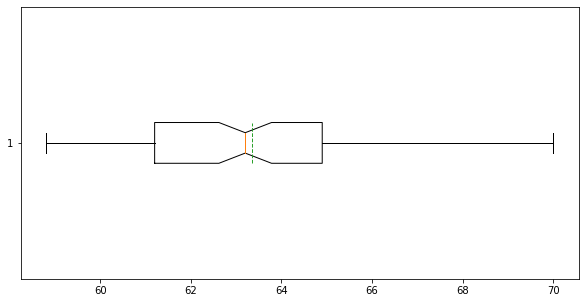

In [28]:
plt.figure(figsize=(10, 5))
plt.boxplot(tabela_acertos, vert = False, meanline = True, showcaps = True, showbox = True, showfliers = True, showmeans = True, notch = True, manage_ticks = True)
plt.show()

ValueError: X must have 2 or fewer dimensions

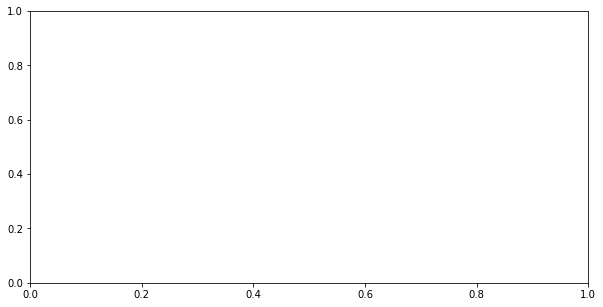

In [29]:
plt.figure(figsize=(10,5))
data = [train, test]
plt.boxplot(data, vert = False, meanline = True, showcaps = True, showbox = True, showfliers = True, showmeans = True, notch = True, manage_ticks = True)
plt.show()

___
## checklist itens extra

- [x] Espaçamento entre emojis
- [x] 4 categorias (obrigatorio)
- [x] Explicar porque não pode usar o classificador para gerar mais dados de treinamento
- [x] Fazer o item 6
- [x] Propor outro cenario para naive-bayes
- [x] Sugerir melhoria com pesquisa
#### Limpezas e transformacoes:
    - [x] Stopwords
    - [x] Nomes de usuario
    - [x] Limpeza de urls




___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CORRIGIU separação de espaços entre palavras e emojis ou entre emojis e emojis
* CRIOU categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante. Pelo menos quatro categorias, com adição de mais tweets na base, conforme enunciado. (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item 6. Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

----
## Referencias:
* https://mathiasbynens.be/demo/url-regex
* https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.htmlhttps://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html